In [12]:
import pandas as pd
import numpy as np

# Loading the Excel file
file_path = r'C:\Users\youss\Downloads\Data.xlsx'
xls = pd.ExcelFile(file_path)

# Loading each sheet into a dataframe
sales_orders_df = pd.read_excel(xls, sheet_name='Sales_orders')
cost_of_goods_df = pd.read_excel(xls, sheet_name='Cost_of_Goods')
product_sales_order_df = pd.read_excel(xls, sheet_name='Product_sales_order')

# Step 1: Drop rows with missing sales values
sales_orders_df = sales_orders_df.dropna(subset=['SALES'])

# Step 2: Ensure DATE column is in datetime format
sales_orders_df['DATE'] = pd.to_datetime(sales_orders_df['DATE'])

# Step 3: Ensure SALES column is in float format
sales_orders_df['SALES'] = sales_orders_df['SALES'].astype(float)

# Step 4: Check for and remove duplicate records
sales_orders_df = sales_orders_df.drop_duplicates()
cost_of_goods_df = cost_of_goods_df.drop_duplicates()
product_sales_order_df = product_sales_order_df.drop_duplicates()

# Additional Step: Handle negative sales values
negative_sales = sales_orders_df[sales_orders_df['SALES'] < 0]
print("Negative Sales Entries:")
print(negative_sales)

# Remove negative sales values
sales_orders_df = sales_orders_df[sales_orders_df['SALES'] >= 0]

# Calculate total sales per day for delivered orders
delivered_orders_df = sales_orders_df[sales_orders_df['Order_status'] == 'Delivered']
total_sales_per_day = delivered_orders_df.groupby('DATE')['SALES'].sum().reset_index()
total_sales_per_day.columns = ['Date', 'Total_Sales']

# Save the cleaned data and the result to a new Excel file
cleaned_file_path = r'C:\Users\youss\Downloads\Data.xlsx'
with pd.ExcelWriter(cleaned_file_path) as writer:
    sales_orders_df.to_excel(writer, sheet_name='Sales_orders', index=False)
    cost_of_goods_df.to_excel(writer, sheet_name='Cost_of_Goods', index=False)
    product_sales_order_df.to_excel(writer, sheet_name='Product_sales_order', index=False)
    total_sales_per_day.to_excel(writer, sheet_name='Total_Sales_Per_Day', index=False)

print(f'Cleaned data saved to {cleaned_file_path}')


Negative Sales Entries:
      ORDER_ID       DATE DAY_NAME Order_status       SALES
4712   6418568 2023-10-06      Fri    Delivered -10000000.0
Cleaned data saved to C:\Users\youss\Downloads\Data.xlsx


In [15]:
# Load the relevant sheets into dataframes
sales_orders_df = pd.read_excel(file_path, sheet_name='Sales_orders')
cost_of_goods_df = pd.read_excel(file_path, sheet_name='Cost_of_Goods')
product_sales_order_df = pd.read_excel(file_path, sheet_name='Product_sales_order')

# Merge Product_sales_order with Cost_of_Goods on PRODUCT_ID
merged_df = product_sales_order_df.merge(cost_of_goods_df, left_on='PRODUCT_ID', right_on='product_id')

# Filter out rows with negative purchase_price and extreme values
merged_df = merged_df[(merged_df['purchase_price'] >= 0) & (merged_df['purchase_price'] < 1e6) & (merged_df['selling_price'] > 0)]

# Calculate gross profit per product per order
merged_df['gross_profit'] = (merged_df['selling_price'] - merged_df['purchase_price']) * merged_df['SALES'] / merged_df['selling_price']

# Group by PRODUCT_ID to calculate total gross profit per product
total_gross_profit_per_product = merged_df.groupby('PRODUCT_ID')['gross_profit'].sum().reset_index()

# Merge with Cost_of_Goods to get product details
total_gross_profit_per_product = total_gross_profit_per_product.merge(cost_of_goods_df, left_on='PRODUCT_ID', right_on='product_id')

# Sort products by gross profit
total_gross_profit_per_product_sorted = total_gross_profit_per_product.sort_values(by='gross_profit', ascending=False)

# Get the top 3 and bottom 3 products by gross profit
top_gross_profit_products = total_gross_profit_per_product_sorted.head(3)
bottom_gross_profit_products = total_gross_profit_per_product_sorted.tail(3)

print("Top 3 Gross Profit Products:\n", top_gross_profit_products)
print("\nBottom 3 Gross Profit Products:\n", bottom_gross_profit_products)

Top 3 Gross Profit Products:
     PRODUCT_ID  gross_profit  product_id  purchase_price  selling_price
5          583  62712.854439         583          263.05         278.75
21        9081  57319.618160        9081           67.21          72.00
12        2438  44789.104942        2438           40.89          43.00

Bottom 3 Gross Profit Products:
     PRODUCT_ID  gross_profit  product_id  purchase_price  selling_price
11        1765   2097.124847        1765          157.19         163.00
14        3495    524.800000        3495           20.01          21.75
10        1222    221.358879        1222          345.67         350.00


C:\Users\youss\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


        DATE  PREDICTED_SALES
0 2023-10-22       365.212918
1 2023-10-23       362.824828
2 2023-10-24       360.436739
3 2023-10-25       358.048649
4 2023-10-26       355.660560
5 2023-10-27       353.272471
6 2023-10-28       350.884381
Total predicted sales for the 4th week: 2506.340546433419
Contribution of Wednesday: 14.29%
Contribution of Friday: 14.10%
Predicted highest sales day for the 4th week:
DATE               2023-10-22 00:00:00
PREDICTED_SALES             365.212918
DAY_NAME                        Sunday
Name: 0, dtype: object


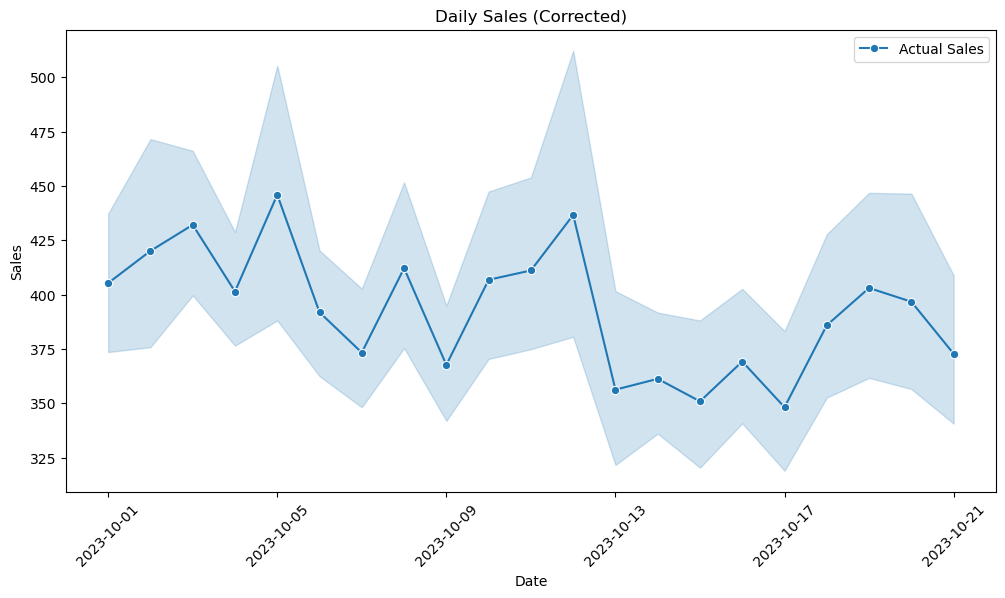

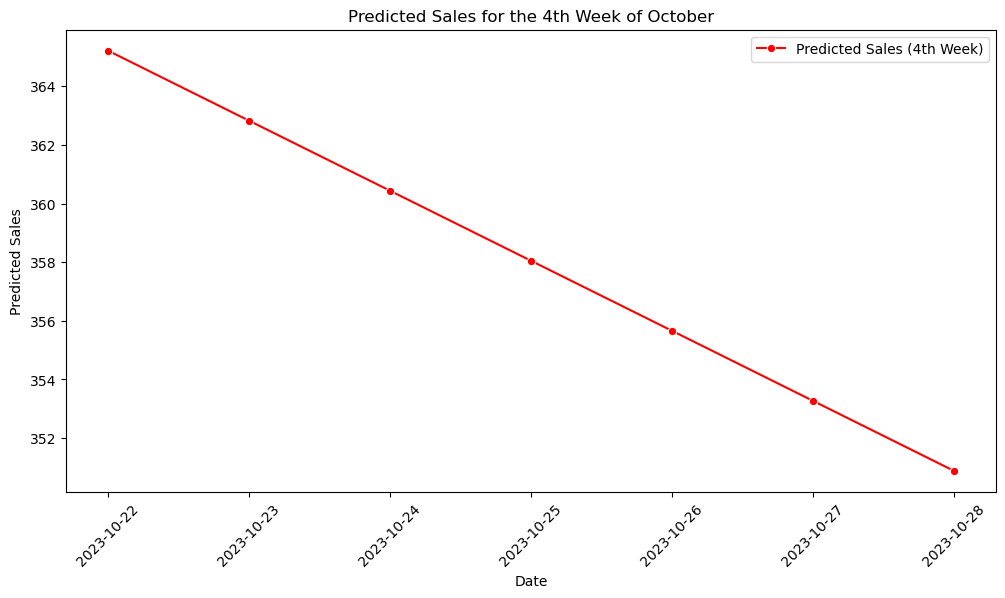

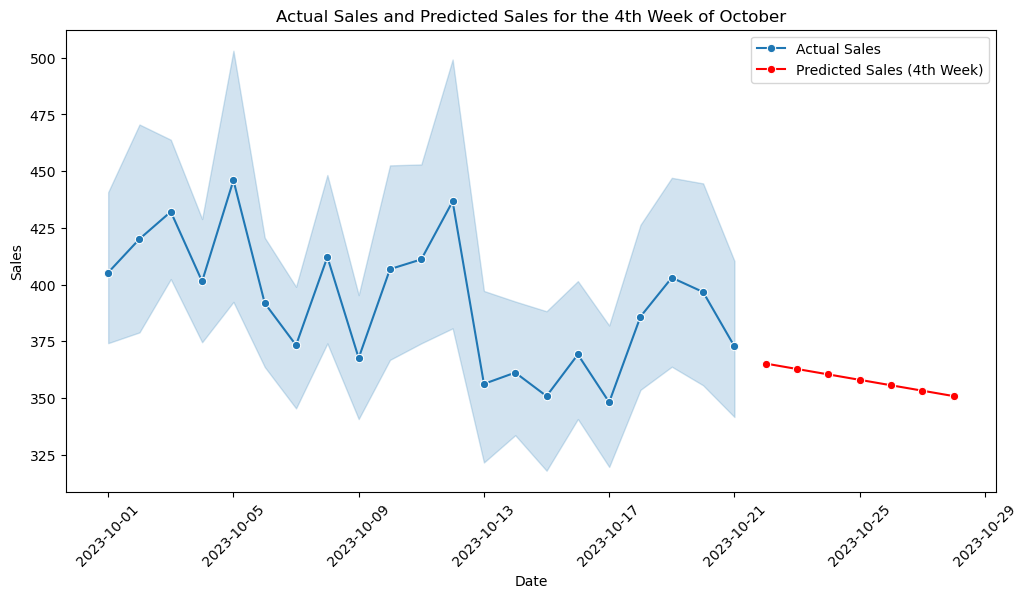

In [14]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Load the sales data from the provided Excel file
file_path = r'C:\Users\youss\Downloads\Cleaned_Data.xlsx'
sales_data = pd.read_excel(file_path)

# Convert DATE column to datetime
sales_data['DATE'] = pd.to_datetime(sales_data['DATE'])
sales_data['DAY_NUMBER'] = sales_data['DATE'].dt.dayofyear
sales_data['DAY_NAME'] = sales_data['DATE'].dt.day_name()

# Filter only delivered sales
delivered_sales = sales_data[sales_data['Order_status'] == 'Delivered']


# Use the first 3 weeks of data for training (2023-10-01 to 2023-10-21)
train_data = delivered_sales[delivered_sales['DATE'] <= '2023-10-21']

# Prepare the features (X) and target (y)
X_train = train_data[['DAY_NUMBER']]
y_train = train_data['SALES']

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the 4th-week sales (from 22nd to 28th of October)
dates_4th_week = pd.date_range(start='2023-10-22', end='2023-10-28')
day_numbers_4th_week = dates_4th_week.dayofyear.values.reshape(-1, 1)
predicted_sales_4th_week = model.predict(day_numbers_4th_week)

# Create a DataFrame for the predictions
predicted_sales_4th_week_df = pd.DataFrame({
    'DATE': dates_4th_week,
    'PREDICTED_SALES': predicted_sales_4th_week
})

print(predicted_sales_4th_week_df)

# Identify the dates corresponding to Wednesday and Friday in the 4th week
wednesday_date = predicted_sales_4th_week_df[predicted_sales_4th_week_df['DATE'].dt.day_name() == 'Wednesday']['DATE'].values[0]
friday_date = predicted_sales_4th_week_df[predicted_sales_4th_week_df['DATE'].dt.day_name() == 'Friday']['DATE'].values[0]

# Extract the predicted sales for Wednesday and Friday
wednesday_sales = predicted_sales_4th_week_df[predicted_sales_4th_week_df['DATE'] == wednesday_date]['PREDICTED_SALES'].values[0]
friday_sales = predicted_sales_4th_week_df[predicted_sales_4th_week_df['DATE'] == friday_date]['PREDICTED_SALES'].values[0]

# Calculate the total predicted sales for the 4th week
total_predicted_sales_4th_week = predicted_sales_4th_week_df['PREDICTED_SALES'].sum()

# Calculate the contribution of Wednesday and Friday
wednesday_contribution = (wednesday_sales / total_predicted_sales_4th_week) * 100
friday_contribution = (friday_sales / total_predicted_sales_4th_week) * 100

# Identify the highest sales day in the 4th week
predicted_sales_4th_week_df['DAY_NAME'] = predicted_sales_4th_week_df['DATE'].dt.day_name()
highest_sales_day_4th_week = predicted_sales_4th_week_df.loc[predicted_sales_4th_week_df['PREDICTED_SALES'].idxmax()]

# Print results
print(f"Total predicted sales for the 4th week: {total_predicted_sales_4th_week}")
print(f"Contribution of Wednesday: {wednesday_contribution:.2f}%")
print(f"Contribution of Friday: {friday_contribution:.2f}%")
print("Predicted highest sales day for the 4th week:")
print(highest_sales_day_4th_week)

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=delivered_sales, x='DATE', y='SALES', marker='o', label='Actual Sales')
plt.xticks(rotation=45)
plt.title('Daily Sales (Corrected)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot predicted sales for the 4th week
plt.figure(figsize=(12, 6))
sns.lineplot(data=predicted_sales_4th_week_df, x='DATE', y='PREDICTED_SALES', marker='o', color='red', label='Predicted Sales (4th Week)')
plt.xticks(rotation=45)
plt.title('Predicted Sales for the 4th Week of October')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.legend()
plt.show()

# Combined plot of actual sales and predicted sales for the 4th week
plt.figure(figsize=(12, 6))
sns.lineplot(data=delivered_sales, x='DATE', y='SALES', marker='o', label='Actual Sales')
sns.lineplot(data=predicted_sales_4th_week_df, x='DATE', y='PREDICTED_SALES', marker='o', color='red', label='Predicted Sales (4th Week)')
plt.xticks(rotation=45)
plt.title('Actual Sales and Predicted Sales for the 4th Week of October')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [16]:
total_sales_per_day = delivered_orders_df.groupby('DATE')['SALES'].sum().reset_index()

# Rename columns for clarity
total_sales_per_day.columns = ['Date', 'Total_Sales']

# Display the result
print(total_sales_per_day)

         Date  Total_Sales
0  2023-10-01  370872.2520
1  2023-10-02  320557.9300
2  2023-10-03  449848.7280
3  2023-10-04  437969.1700
4  2023-10-05  225666.1423
5  2023-10-06  228052.5163
6  2023-10-07  342714.6800
7  2023-10-08  393627.0280
8  2023-10-09  313617.1963
9  2023-10-10  275830.0620
10 2023-10-11  324794.7800
11 2023-10-12  234056.8850
12 2023-10-13  173854.8000
13 2023-10-14  277795.6370
14 2023-10-15  264212.0960
15 2023-10-16  290943.0080
16 2023-10-17  232227.5930
17 2023-10-18  298317.2095
18 2023-10-19  254330.9155
19 2023-10-20  203526.5035
20 2023-10-21  281832.0760
